<a href="https://colab.research.google.com/github/madelezhia/vision-systems-lab/blob/main/IV-Action/Classification_and_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You will be using the [Aircraft dataset](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar).
The dataset is taken from the here (Original Source): [Roboflow Aircraft Dataset](https://universe.roboflow.com/youssef-donia-fhktl/aircraft-damage-detection-1j9qk) Provided by a Roboflow user, License: CC BY 4.


# Dataset-Preparation


## Setup


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pandas==2.2.3
!pip install tensorflow==2.17.1
!pip install pillow==11.1.0
!pip install matplotlib==3.9.2
!pip install transformers==4.38.2
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


ERROR: Operation cancelled by user
^C


In [ ]:
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [ ]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Classification



In [ ]:
#Set the batch size,epochs
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

In [ ]:
import tarfile
import os
import shutil

# Define the path to save the file
tar_filename = "/gdrive/MyDrive/Colab Notebooks/Portfolio/IV-Action/aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")

    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")


/tmp/ipython-input-2252806647.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall()  # This will extract to the current directory


Extracted /gdrive/MyDrive/Colab Notebooks/Portfolio/IV-Action/aircraft_damage_dataset_v1.tar successfully.


In [ ]:
# Define directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

In [ ]:
# Create ImageDataGenerators to preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 300 images belonging to 2 classes.


In [ ]:
valid_generator =  valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)


Found 96 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 50 images belonging to 2 classes.


In [ ]:
base_model = VGG16(weights='imagenet' , include_top=False , input_shape=(img_rows, img_cols, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Build the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

### Model Training



In [ ]:
history = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=valid_generator,
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 358s 35s/step - accuracy: 0.5192 - loss: 0.7190 - val_accuracy: 0.6042 - val_loss: 0.6338
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 300s 31s/step - accuracy: 0.7010 - loss: 0.5582 - val_accuracy: 0.6979 - val_loss: 0.5821
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 276s 29s/step - accuracy: 0.7865 - loss: 0.4846 - val_accuracy: 0.7188 - val_loss: 0.5486
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 266s 27s/step - accuracy: 0.8258 - loss: 0.3879 - val_accuracy: 0.6562 - val_loss: 0.6457
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 254s 26s/step - accuracy: 0.8663 - loss: 0.3421 - val_accuracy: 0.7083 - val_loss: 0.5098


In [ ]:
# Access the training history
train_history = model.history.history  # After training

## Visualizing Training Results

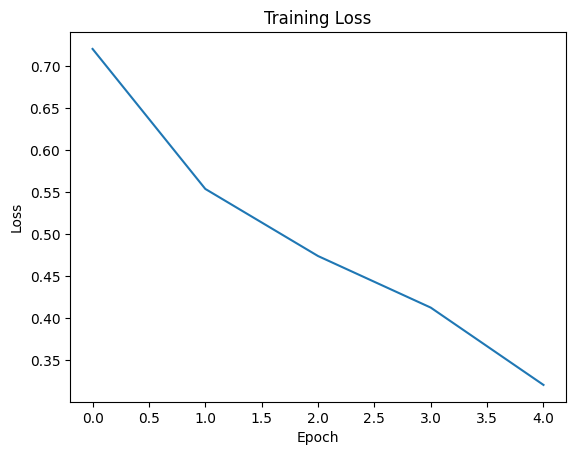

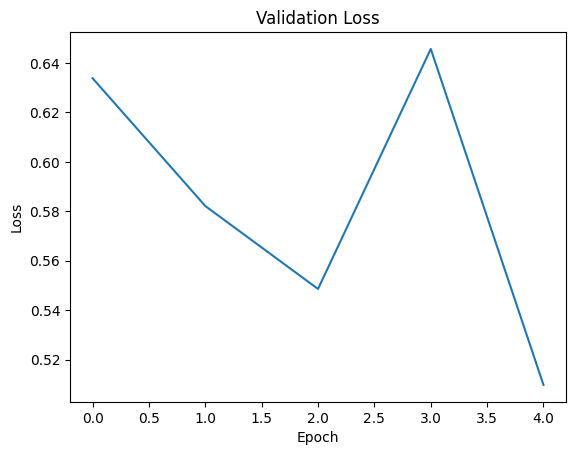

In [ ]:
# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

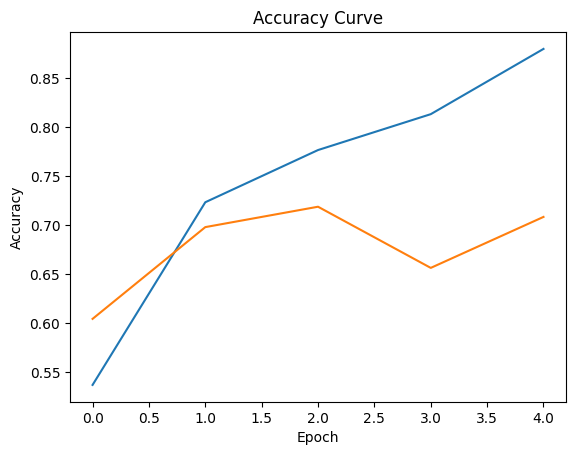

In [ ]:
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.show()

## Model Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.6875 - loss: 0.7326
Test Loss: 0.7326
Test Accuracy: 0.6875


 ## Visualizing Predictions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras._tf_keras.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)




1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


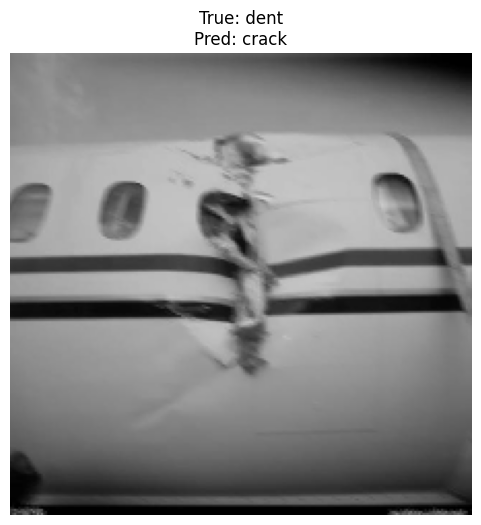

In [ ]:
test_model_on_image(test_generator, model, index_to_plot=1)

# Image Captioning and Summarization using BLIP Pretrained Model


In [ ]:
#Load the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

In [ ]:
#load the pretrained BLIP processor and model:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"


### Implement a Helper Function to Use the Custom Keras Layer

In [ ]:
# Write your code here
def generate_text(image_path, task):
  # Create an instance of the custom Keras layer
  # Replace this with the pretrained BLIP processor and model loaded earlier
    blip_layer = BlipCaptionSummaryLayer(processor, model)
    # Call the layer with the provided inputs
    return blip_layer(image_path, task)


### Generating Captions and Summaries


In [ ]:

# Path to an example image
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


### Generate a caption for an image using the using BLIP pretrained model

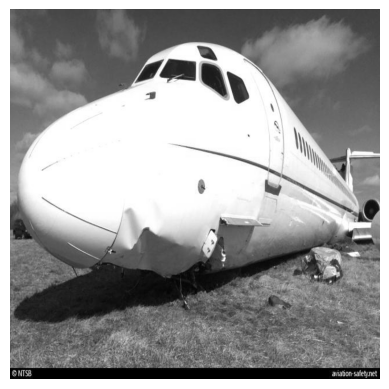

In [ ]:
image_path = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
# Load and display the image
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image

In [ ]:
# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

Caption: this is a picture of a plane that was sitting on the ground in a field


In [ ]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image

In [ ]:
# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Summary: this is a detailed photo showing the damage to the fuselage of the aircraft
